In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

The dataset is about forest fire in Portugal, detailed information can be found here: http://archive.ics.uci.edu/ml/datasets/Forest+Fires

# Atribut Information

For more information, read [Cortez and Morais, 2007].

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: 'jan' to 'dec'
- day - day of the week: 'mon' to 'sun'
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3
- DC - DC index from the FWI system: 7.9 to 860.6
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

In [2]:
data = pd.read_csv('../dataset/forestfires.csv')

In [3]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
data.shape

(517, 13)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


### Additional Information

WEATHER

Sources:
https://www.auburn.edu/academic/forestry_wildlife/fire/weather_elements.htm

- Air temperature has a direct influence on fire behavior because of the heat requirements for ignition and continuing the combustion process.
- The temperature is the highest at that time resulting in higher fuel temperatures. Consequently, less heat is needed to raise the fuel to its ignition temperature. At the same time rising temperatures result in decreasing relative humidity and fuel moisture.
- Wind has a strong effect on fire behavior due to the fanning effect on the fire. Wind increases the supply of oxygen, which results in the fire burning more rapidly. Wind influences the rate of spread and intensity of the fire. 
- The lower the relative humidity, the more readily a fire will start and burn; the more vigorously a fire will burn. This is because relative humidity is changed by temperature.
- Precipitation will quickly dampen the surface of fuels to the point that fires cannot ignite and no wildfires will occur. During long periods of dry weather, drought, moisture that is toward the center of larger fuels and deeper in surface litter is able to work its way to the surface and evaporate into the dry atmosphere.  As a result, a larger percent of the total fuel becomes available fuel; available to burn.

Conclusion:
There will be more fire when Temperature is higher, Humidity (RH) is lower, Precipitation (Rain) is lower, and Wind is stronger.

FIRE WEATHER INDEX

Sources:
https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system

There 3 main processes:
- Fire Weather Observation : Temperature, Relative Humidity, Rain, and Wind.
- Fuel Moisture Codes: FFMC (Temperature, Relative Humidity, Rain, and Wind), DMC (Temperature, Relative Humidity, and Wind), DC (Temperature and Rain)
- Fire Behaviour Indices : ISI (Wind + FFMC) - as the fires Spread Component (SC).

---

# Data Preparation

In [7]:
data['area_categorical'] = data['area'].apply(lambda x:1 if x > 0 else 0)

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['month'] = encoder.fit_transform(data['month'])
data['day'] = encoder.fit_transform(data['day'])

In [9]:
data['location'] = data['X'].astype('string')+'-'+data['Y'].astype('string')

In [10]:
data['location'] = encoder.fit_transform(data['location'])

In [11]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_categorical,location
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,25
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,24
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,24
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,30
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,30


---

# Base Model with RF

In [12]:
X = data.drop(['area_categorical','area','X','Y'], axis = 1)
y = data['area_categorical']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.7, 
                                                      test_size=0.3,
                                                      random_state=42)

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [15]:
y_pred = model.predict(X_valid)

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54        77
           1       0.58      0.67      0.62        79

    accuracy                           0.58       156
   macro avg       0.58      0.58      0.58       156
weighted avg       0.58      0.58      0.58       156



In [17]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,38,39
1,26,53


In [18]:
y_pred_ = model.predict(X_train)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       170
           1       0.99      0.99      0.99       191

    accuracy                           0.99       361
   macro avg       0.99      0.99      0.99       361
weighted avg       0.99      0.99      0.99       361



In [20]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_train, y_pred_))

,0,1
0,168,2
1,1,190


RF is tend to overfit with much higher F1-Score accuracy compare to the validation dataset

---

# Feature Engineering

## Clustering

In [22]:
from sklearn.cluster import KMeans

### Weather Cluster

In [23]:
features_weather = ['X', 'Y', 'month', 'temp', 'RH', 'wind', 'rain']

kmeans = KMeans(n_clusters=2)
data["cluster_weather"] = kmeans.fit_predict(data[features_weather])
data["cluster_weather"] = data["cluster_weather"].astype("category")

data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_categorical,location,cluster_weather
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,25,0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,24,1
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,24,1
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,30,0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,30,0


### Fire Weather Index Cluster

In [24]:
features_index = ['X', 'Y', 'month', 'FFMC', 'DMC', 'DC', 'ISI']

kmeans = KMeans(n_clusters=2)
data["cluster_weather_index"] = kmeans.fit_predict(data[features_index])
data["cluster_weather_index"] = data["cluster_weather_index"].astype("category")

data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_categorical,location,cluster_weather,cluster_weather_index
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,25,0,1
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,24,1,0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,24,1,0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,30,0,1
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,30,0,1


In [25]:
X = data.drop(['X','Y','area_categorical'], axis = 1)
y = data['area_categorical']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.8, 
                                                      test_size=0.2,
                                                      random_state=42)

In [27]:
X_train["area_weather"] = X_train.groupby("cluster_weather")["area"].transform("max")

# Merge the values into the validation set
X_valid = X_valid.merge(
    X_train[["cluster_weather", "area_weather"]].drop_duplicates(),
    on="cluster_weather",
    how="left",
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
X_train["area_weather_index"] = X_train.groupby("cluster_weather_index")["area"].transform("max")

# Merge the values into the validation set
X_valid = X_valid.merge(
    X_train[["cluster_weather_index", "area_weather_index"]].drop_duplicates(),
    on="cluster_weather_index",
    how="left",
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
X_train["area_month_max"] = X_train.groupby("month")["area"].transform("max")

# Merge the values into the validation set
X_valid = X_valid.merge(
    X_train[["month", "area_month_max"]].drop_duplicates(),
    on="month",
    how="left",
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
X_train = X_train.drop(['area','day'], axis = 1)
X_valid = X_valid.drop(['area','day'], axis = 1)

In [31]:
X_train.columns

Index(['month', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'location', 'cluster_weather', 'cluster_weather_index', 'area_weather',
       'area_weather_index', 'area_month_max'],
      dtype='object')

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

threshold = 7

skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(X_train, y_train)
sel_skb_index = sel_skb.get_support()

sel_skb_index

array([False, False,  True,  True, False,  True, False, False, False,
        True, False, False,  True,  True,  True])

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

threshold = 7

skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(X_valid, y_valid)
sel_skb_index = sel_skb.get_support()

sel_skb_index

array([ True, False, False,  True, False,  True,  True, False, False,
       False, False, False,  True,  True,  True])

Selected : DC, temp, area_weather, area_weather_index, area_month_max

In [34]:
X_train = X_train[['DC','temp','area_weather','area_weather_index','area_month_max']]
X_valid = X_valid[['DC','temp','area_weather','area_weather_index','area_month_max']]

### Testing - RF

In [36]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
y_pred = model.predict(X_valid)

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67        51
           1       0.69      0.66      0.67        53

    accuracy                           0.67       104
   macro avg       0.67      0.67      0.67       104
weighted avg       0.67      0.67      0.67       104



In [39]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,35,16
1,18,35


In [40]:
y_pred_ = model.predict(X_train)

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       196
           1       0.97      0.96      0.97       217

    accuracy                           0.97       413
   macro avg       0.97      0.97      0.97       413
weighted avg       0.97      0.97      0.97       413



In [42]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_train, y_pred_))

,0,1
0,190,6
1,8,209


---

# Neural Network

In [47]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

import keras_tuner as kt

## Hyperparameter Tuning

In [43]:
X_train.shape

(413, 5)

In [446]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(Dense(10, input_shape=(5,), activation='relu', kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate=0.25))
  
  hp_units_1 = hp.Int('units_1', min_value=4, max_value=32, step=2)
  hp_activation_1 = hp.Choice('dense_activation_1', values=['relu', 'tanh', 'sigmoid'])
  model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_1, kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate=0.25))
    
  hp_units_2 = hp.Int('units_2', min_value=4, max_value=32, step=2)
  hp_activation_2 = hp.Choice('dense_activation_2', values=['relu', 'tanh', 'sigmoid']) 
  model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_2, kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate=0.25))
    
  hp_units_3 = hp.Int('units_3', min_value=4, max_value=32, step=2)
  hp_activation_3 = hp.Choice('dense_activation_3', values=['relu', 'tanh', 'sigmoid']) 
  model.add(keras.layers.Dense(units=hp_units_3, activation=hp_activation_3, kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate=0.25))
  
  hp_units_4 = hp.Int('units_4', min_value=4, max_value=32, step=2)
  hp_activation_4 = hp.Choice('dense_activation_4', values=['relu', 'tanh', 'sigmoid']) 
  model.add(keras.layers.Dense(units=hp_units_4, activation=hp_activation_4, kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate=0.25))

  hp_units_5 = hp.Int('units_5', min_value=4, max_value=32, step=2)
  hp_activation_5 = hp.Choice('dense_activation_5', values=['relu', 'tanh', 'sigmoid']) 
  model.add(keras.layers.Dense(units=hp_units_5, activation=hp_activation_5, kernel_initializer = 'he_uniform'))
  model.add(Dropout(rate=0.25))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[tensorflow.keras.metrics.AUC()])

  return model

In [447]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("auc", direction="max"),
                     max_epochs=100,
                     directory='my_dir_final',
                     project_name='intro_to_kt_2')

In [448]:
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [449]:
tuner.search(X_train, 
             y_train, 
             epochs=100, 
             validation_split=0.2, 
             callbacks=[stop_early],
             batch_size=32)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=5)[0]

Trial 254 Complete [00h 00m 03s]
auc: 0.5322520732879639

Best auc So Far: 0.6050955057144165
Total elapsed time: 00h 11m 04s
INFO:tensorflow:Oracle triggered exit


In [450]:
best_hps.get('units_1')

4

In [451]:
best_hps.get('dense_activation_1')

'sigmoid'

In [452]:
best_hps.get('units_2')

14

In [453]:
best_hps.get('dense_activa tion_2')

'tanh'

In [454]:
best_hps.get('units_3')

14

In [455]:
best_hps.get('dense_activation_3')

'tanh'

In [456]:
best_hps.get('units_4')

6

In [457]:
best_hps.get('dense_activation_4')

'sigmoid'

In [458]:
best_hps.get('units_5')

16

In [459]:
best_hps.get('dense_activation_5')

'tanh'

In [470]:
# Define Model

model = Sequential()

model.add(Dense(10, input_shape=(5,), activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(4, activation='sigmoid', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(16, activation='tanh', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(6, activation='sigmoid', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[tensorflow.keras.metrics.AUC()])
    
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min')

# Fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2,
                    epochs=500,
                    callbacks=[stop_early],
                    batch_size=32)

Epoch 1/500
11/11 [==============================] - 0s 45ms/step - loss: 0.7621 - auc_3: 0.5047 - val_loss: 0.7549 - val_auc_3: 0.4062
Epoch 2/500
11/11 [==============================] - 0s 10ms/step - loss: 0.7526 - auc_3: 0.4825 - val_loss: 0.7369 - val_auc_3: 0.4161
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 0.7457 - auc_3: 0.4805 - val_loss: 0.7195 - val_auc_3: 0.4298
Epoch 4/500
11/11 [==============================] - 0s 7ms/step - loss: 0.7255 - auc_3: 0.4927 - val_loss: 0.7145 - val_auc_3: 0.4304
Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 0.7283 - auc_3: 0.4892 - val_loss: 0.7085 - val_auc_3: 0.4164
Epoch 6/500
11/11 [==============================] - 0s 9ms/step - loss: 0.7193 - auc_3: 0.5100 - val_loss: 0.7066 - val_auc_3: 0.3980
Epoch 7/500
11/11 [==============================] - 0s 5ms/step - loss: 0.7203 - auc_3: 0.4895 - val_loss: 0.7020 - val_auc_3: 0.4088
Epoch 8/500
11/11 [==============================] - 

11/11 [==============================] - 0s 7ms/step - loss: 0.6906 - auc_3: 0.5270 - val_loss: 0.6929 - val_auc_3: 0.5000
Epoch 62/500
11/11 [==============================] - 0s 8ms/step - loss: 0.6962 - auc_3: 0.4966 - val_loss: 0.6930 - val_auc_3: 0.5006
Epoch 63/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6835 - auc_3: 0.5813 - val_loss: 0.6930 - val_auc_3: 0.5035
Epoch 64/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6929 - auc_3: 0.5149 - val_loss: 0.6930 - val_auc_3: 0.5035
Epoch 65/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6979 - auc_3: 0.4788 - val_loss: 0.6926 - val_auc_3: 0.5102
Epoch 66/500
11/11 [==============================] - 0s 7ms/step - loss: 0.6929 - auc_3: 0.5254 - val_loss: 0.6927 - val_auc_3: 0.5067
Epoch 67/500
11/11 [==============================] - 0s 6ms/step - loss: 0.6839 - auc_3: 0.5817 - val_loss: 0.6928 - val_auc_3: 0.5067
Epoch 68/500
11/11 [==============================] - 0s 7ms/

11/11 [==============================] - 0s 11ms/step - loss: 0.6968 - auc_3: 0.4560 - val_loss: 0.6921 - val_auc_3: 0.5181
Epoch 122/500
11/11 [==============================] - 0s 9ms/step - loss: 0.6924 - auc_3: 0.4947 - val_loss: 0.6919 - val_auc_3: 0.5192
Epoch 123/500
11/11 [==============================] - 0s 8ms/step - loss: 0.6943 - auc_3: 0.5135 - val_loss: 0.6919 - val_auc_3: 0.5192
Epoch 124/500
11/11 [==============================] - 0s 6ms/step - loss: 0.6921 - auc_3: 0.5183 - val_loss: 0.6920 - val_auc_3: 0.5192
Epoch 125/500
11/11 [==============================] - 0s 12ms/step - loss: 0.6966 - auc_3: 0.4784 - val_loss: 0.6921 - val_auc_3: 0.5169
Epoch 126/500
11/11 [==============================] - 0s 9ms/step - loss: 0.6962 - auc_3: 0.4698 - val_loss: 0.6921 - val_auc_3: 0.5169
Epoch 127/500
11/11 [==============================] - 0s 8ms/step - loss: 0.6922 - auc_3: 0.5048 - val_loss: 0.6921 - val_auc_3: 0.5169
Epoch 128/500
11/11 [==============================] 

In [471]:
y_pred = model.predict_classes(X_valid)

In [472]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.51      1.00      0.68        53

    accuracy                           0.51       104
   macro avg       0.25      0.50      0.34       104
weighted avg       0.26      0.51      0.34       104



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [473]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,0,51
1,0,53


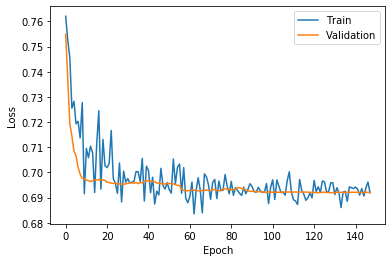

In [474]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [557]:
def fit_model(X_train, y_train, X_valid, y_valid, n_batch):

    model = Sequential()

    model.add(Dense(10, input_shape=(5,), activation='relu', kernel_initializer = 'he_uniform'))
    model.add(Dropout(rate=0.25))

    model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
    model.add(Dropout(rate=0.25))
    
    model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
    model.add(Dropout(rate=0.25))

    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[tensorflow.keras.metrics.AUC()])
    
    stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min')

    # Fit model
    history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2,
                    epochs=1000,
                    callbacks=[stop_early],
                    batch_size=n_batch,
                    verbose=0)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('batch='+str(n_batch))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

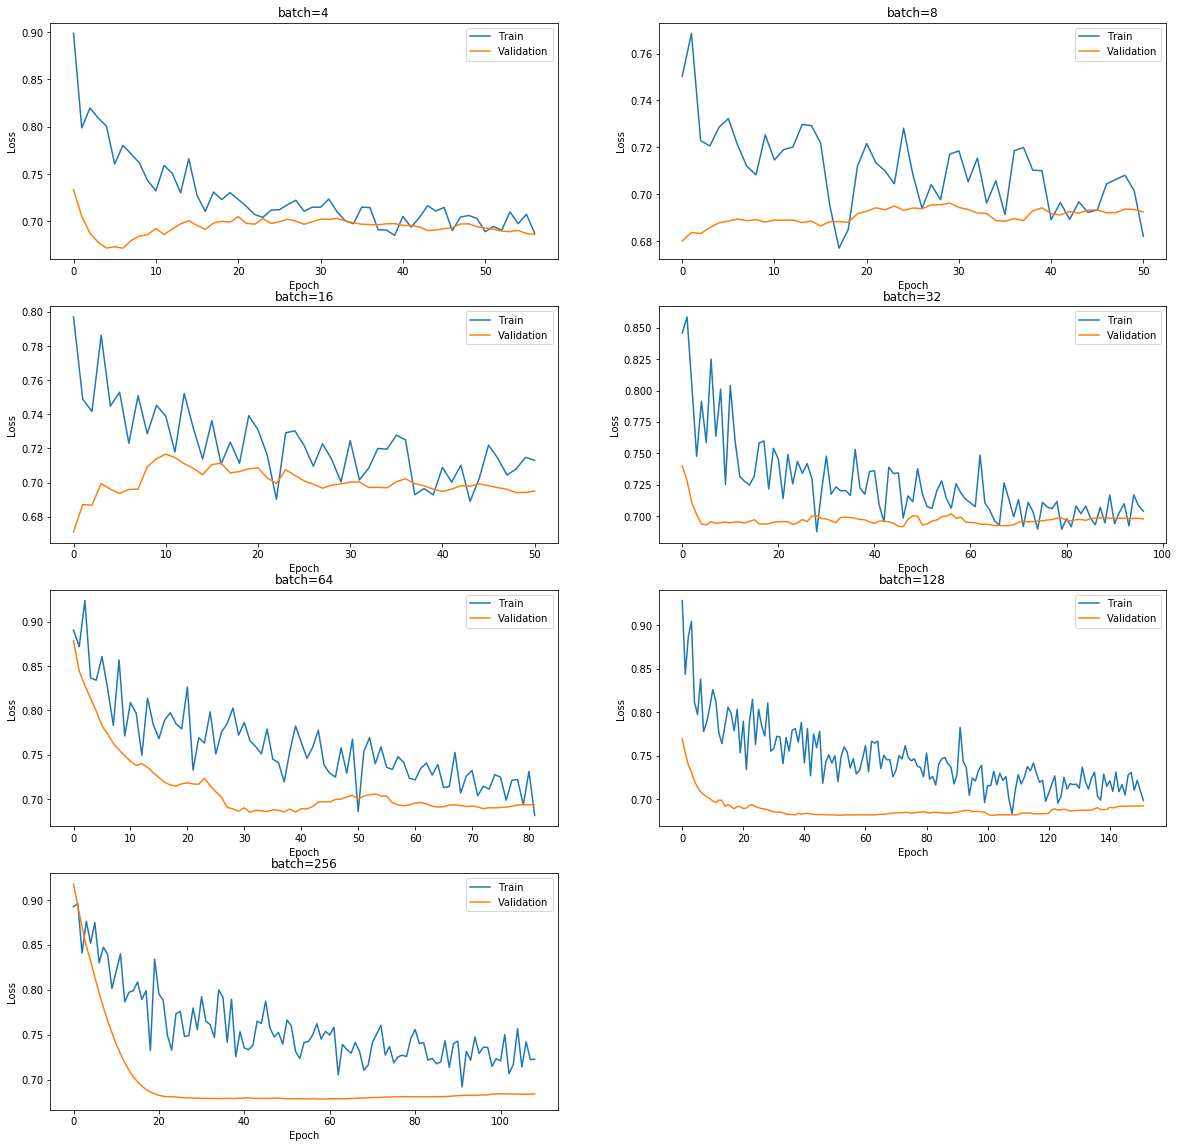

In [558]:
# create learning curves for different batch sizes
batch_sizes = [4, 8, 16, 32, 64, 128, 256]

plt.figure(figsize=(20, 20))

for i in range(len(batch_sizes)):
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    fit_model(X_train, y_train, X_valid, y_valid, batch_sizes[i])
plt.show()

In [620]:
# Define Model

model = Sequential()

model.add(Dense(10, input_shape=(5,), activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(14, activation='tanh', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.25))

model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[tensorflow.keras.metrics.AUC()])
    
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')

# Fit model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=1000,
                    callbacks=[stop_early],
                    batch_size=8)

Epoch 1/1000
52/52 [==============================] - 1s 10ms/step - loss: 0.8496 - auc_72: 0.4714 - val_loss: 0.7878 - val_auc_72: 0.4430
Epoch 2/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.8254 - auc_72: 0.4228 - val_loss: 0.7469 - val_auc_72: 0.4504
Epoch 3/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.7525 - auc_72: 0.5146 - val_loss: 0.7301 - val_auc_72: 0.4837
Epoch 4/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.7713 - auc_72: 0.4401 - val_loss: 0.7080 - val_auc_72: 0.4917
Epoch 5/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.7279 - auc_72: 0.5133 - val_loss: 0.7100 - val_auc_72: 0.4587
Epoch 6/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.7047 - auc_72: 0.5511 - val_loss: 0.7053 - val_auc_72: 0.5392
Epoch 7/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.7283 - auc_72: 0.4942 - val_loss: 0.7024 - val_auc_72: 0.5544
Epoch 8/1000
52/52 [=============

Epoch 60/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6920 - auc_72: 0.5285 - val_loss: 0.6844 - val_auc_72: 0.5566
Epoch 61/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.6910 - auc_72: 0.5175 - val_loss: 0.6822 - val_auc_72: 0.5943
Epoch 62/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.7026 - auc_72: 0.4767 - val_loss: 0.6821 - val_auc_72: 0.5936
Epoch 63/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.6938 - auc_72: 0.5199 - val_loss: 0.6816 - val_auc_72: 0.5733
Epoch 64/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.6960 - auc_72: 0.5082 - val_loss: 0.6823 - val_auc_72: 0.5936
Epoch 65/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.6948 - auc_72: 0.5141 - val_loss: 0.6807 - val_auc_72: 0.5990
Epoch 66/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6917 - auc_72: 0.5355 - val_loss: 0.6814 - val_auc_72: 0.6019
Epoch 67/1000
52/52 [======

Epoch 119/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6950 - auc_72: 0.4879 - val_loss: 0.6842 - val_auc_72: 0.5583
Epoch 120/1000
52/52 [==============================] - 0s 2ms/step - loss: 0.6905 - auc_72: 0.5393 - val_loss: 0.6870 - val_auc_72: 0.5392
Epoch 121/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6881 - auc_72: 0.5526 - val_loss: 0.6859 - val_auc_72: 0.5557
Epoch 122/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6923 - auc_72: 0.5114 - val_loss: 0.6864 - val_auc_72: 0.5335
Epoch 123/1000
52/52 [==============================] - 0s 3ms/step - loss: 0.6870 - auc_72: 0.5573 - val_loss: 0.6853 - val_auc_72: 0.5364


In [621]:
y_pred = model.predict_classes(X_valid)

In [622]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.25      0.37        51
           1       0.55      0.87      0.67        53

    accuracy                           0.57       104
   macro avg       0.60      0.56      0.52       104
weighted avg       0.60      0.57      0.52       104



In [623]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1
0,13,38
1,7,46


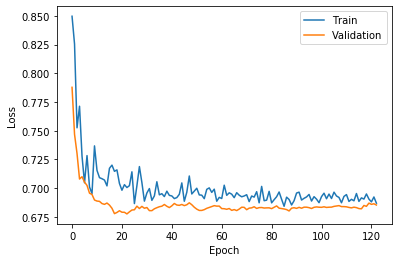

In [624]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [625]:
model.save("model_final")

INFO:tensorflow:Assets written to: model_final/assets


---

# Conclusion

- ANN can not be better than Random Forest (Base Model) even though it showed overfitting for RF.
- Creating Features to give signal about Fires help the model to detect fires, but now the model has difficulties to detect non Fires events.
- ANN Model that are more consistent or stabil showed F1 Score around 50%